In [1]:
import numpy as np
import theano
import theano.tensor as T

Using gpu device 0: GeForce GTX 980 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [2]:
def single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt, exp):
    Area = np.pi * D**2.0 / 4.0
    m = 1.0 / (sqrt(1.0 - CT))
    k = sqrt((m + 1.0) / 2.0)
    R96 = a1 * (exp(a2 * CT**2.0 + a3 * CT + a4)) * (b1 * TI + b2) * D
    x0 = (9.6 * D) / ((2.0 * R96 / (k * D))**3.0 - 1.0)
    term1 = (k * D / 2.0)**2.5
    term2 = (105.0/(2.0*np.pi))**-0.5
    term3 = (CT * Area * x0)**(-5.0 / 6.0)
    c1 = term1 * term2 * term3
    Rw = ((105.0 * c1**2.0 / (2.0 * np.pi))**0.2) * (CT * Area * (x + x0))**(1.0 / 3.0)
    term10=(1./9.)
    term20=(CT*Area*(x+x0)**(-2.))**(1./3.)
    term310=(r**(1.5))
    term320=(3.*c1*c1*CT*Area*(x+x0))**(-0.5)
    term30=term310*term320
    term41=(35./(2.*np.pi))**(3./10.)
    term42=(3.*c1*c1)**(-0.2)
    term40=term41*term42
    dU1=-term10*term20*(term30-term40)**2.
    return dU1, Rw

In [13]:
# gcl = theano.function(inputs=[x, r, CT, TI, D, a1, a2, a3, a4, b1, b2], outputs=[dU, Rw])
D, TI, CT, x, r = T.matrices("D", "TI", "CT", "x", "r")
#a1, a2, a3, a4, b1, b2 = T.dvectors("a1", "a2", "a3", "a4", "b1", "b2")
a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]

dU, Rw = single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt=T.sqrt, exp=T.exp)

# A bit of Theano black magic to do:
# dU[Rw<R_]=0.0 
dU2 = T.set_subtensor(dU[(Rw<r).nonzero()], 0.0)

# dU[X_<0.0]=0.0
dU3 = T.set_subtensor(dU2[(x<0.).nonzero()], 0.0)

gcl_theano = theano.function([x, r, D, TI, CT], [dU3, Rw], allow_input_downcast=True)

In [14]:
gcl_numpy = lambda x, r, D, TI, CT: single_wake(x, r, D, TI, CT, a1, a2, a3, a4, b1, b2, sqrt=np.sqrt, exp=np.exp)

In [24]:
wt_D = 80.0
N = 1000
xs = np.linspace(-2, 10, N, dtype=np.float32) * wt_D
rs = np.linspace(-3, 3, N, dtype=np.float32) * wt_D
x, r = np.meshgrid(xs, rs)
X_ = x
R_ = abs(r)
D_ = wt_D * np.ones_like(X_, dtype=np.float32)
CT_ = 0.80 * np.ones_like(X_, dtype=np.float32)
TI_ = 0.01 * np.ones_like(X_, dtype=np.float32)
#a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]
#a1 *= np.ones_like(x)
#a2 *= np.ones_like(x)
#a3 *= np.ones_like(x)
#b1 *= np.ones_like(x)
#b2 *= np.ones_like(x)

In [19]:
%%timeit
gcl_theano(X_, R_, CT_, TI_, D_)

1 loop, best of 3: 2.25 s per loop


In [20]:
%%timeit
gcl_numpy(X_, R_, CT_, TI_, D_)

1 loop, best of 3: 18 s per loop


In [25]:
X_.shape

(1000, 1000)

In [26]:
dU, Rw = gcl_theano(X_, R_, D_, TI_, CT_)
#dU, Rw = single_wake(X_, R_, D_, TI_, CT_, a1, a2, a3, a4, b1, b2, sqrt=np.sqrt, exp=np.exp)

#dU[Rw<R_]=0.0
#dU[X_<0.0]=0.0

In [27]:
from matplotlib import pylab as plt
%matplotlib inline

(-160.0, 800.0, -240.0, 240.0)

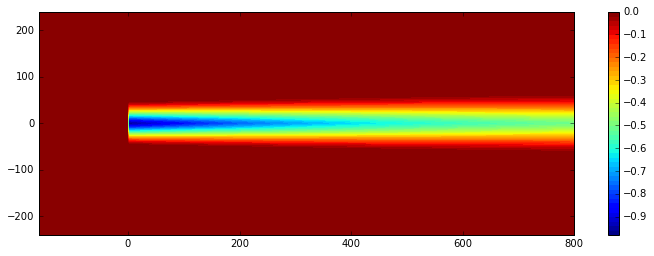

In [28]:
plt.figure(figsize=(12,4))
plt.contourf(xs, rs, dU, 50)
plt.colorbar()
plt.axis('tight')

## Playing with scan

In [29]:
def power_of_2(previous_power, max_value):
    return previous_power*2, theano.scan_module.until(previous_power*2 > max_value)

max_value = T.scalar()
values, _ = theano.scan(power_of_2,
                        outputs_info = T.constant(4.),
                        non_sequences = max_value,
                        n_steps = 1024)

f = theano.function([max_value], values)

print(f(45))

[  8.  16.  32.  64.]


## Building a meshgrid for Theano

In [36]:
x = np.linspace(-10, 10, 20, dtype=np.float32)
R = np.linspace(40, 50, 30, dtype=np.float32)

X_np, R_np = np.meshgrid(x,R)
X_.shape

(1000, 1000)

In [37]:
def test_mesh(X_, R_):
    np.testing.assert_array_almost_equal(X_np, X_)
    np.testing.assert_array_almost_equal(R_np, R_)

In [38]:
def meshgrid(A, B, tile):
    """Theano friendly meshgrid
    """
    return tile(A, (B.size, 1)), tile(B, (A.size, 1)).T

Testing the meshgrid in pure numpy

In [39]:
test_mesh(*meshgrid(x,R, np.tile))

This seems to work fine

#### Building the Theano function

In [40]:
Tx, Tr = T.vectors('x', 'r')
TX, TR = meshgrid(Tx, Tr, T.tile)
Tmeshgrid = theano.function([Tx, Tr], [TX, TR], allow_input_downcast=True)

running the function

In [41]:
test_mesh(*Tmeshgrid(x, R))

All test are passing, Yay!

## Rotor integration 

In [42]:
def get_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight, 
    a1, a2, a3, a4, b1, b2, O=np):
    """Computes the wake velocity deficit at a location

    Inputs
    ----------
    x: float or array
        Distance between wake generating turbines and wake operating
        turbines in the streamwise direction
    y: float or array
        Distance between wake generating turbines and wake operating
        turbine in the crossflow horizontal direction
    z: float or array
        Distance between wake generating turbines and wake operating
        turbine in the crossflow vertical direction
    RT: float
        Wake operating turbine's radius [m]
    R: float or array
        Wake generating turbine's radius [m]
    TI: float
        Ambient turbulence intensity for the wake generating turbine [-]
    CT: float
        Thrust coefficient for the wake generating turbine [-]
    order: int, optional

    Returns
    -------
    dUeq: float
        Rotor averaged wake velocity deficit for each wake operating WT
    """

    # New improved quadrature rule for wake deficit rotor averaging


    x_msh, node_R_msh = meshgrid(x, node_R, O.tile)
    y_msh, node_th_msh = meshgrid(y, node_th, O.tile)
    z_msh, weight_msh = meshgrid(z, weight, O.tile)

    xe = x_msh
    ye = y_msh + RT * node_R_msh * O.cos(node_th_msh)
    ze = z_msh + RT * node_R_msh * O.sin(node_th_msh)
    re = O.sqrt( ye**2. + ze**2. )

    dU_msh, Rw = single_wake(xe, re, 2.0*R, CT, TI, a1, a2, a3, a4, b1, b2, sqrt=O.sqrt, exp=O.exp)
    dUeq = O.sum(weight_msh * dU_msh, axis=0)

    return dUeq

Definition of the nodes

In [43]:
node_R, node_th, weight = np.array([
    [ 0.26349922998554242692 ,  4.79436403870179805864 ,  0.00579798753740115753 ],
    [ 0.26349922998554242692 ,  5.13630491629471475079 ,  0.01299684397858970851 ],
    [ 0.26349922998554242692 ,  5.71955352542765460555 ,  0.01905256317618122044 ],
    [ 0.26349922998554242692 ,  0.20924454049880022999 ,  0.02341643323656225281 ],
    [ 0.26349922998554242692 ,  1.10309379714216659885 ,  0.02569988335562909190 ],
    [ 0.26349922998554242692 ,  2.03849885644762496284 ,  0.02569988335562912660 ],
    [ 0.26349922998554242692 ,  2.93234811309099407950 ,  0.02341643323656214179 ],
    [ 0.26349922998554242692 ,  3.70522443534172518653 ,  0.01905256317618119616 ],
    [ 0.26349922998554242692 ,  4.28847304447466459720 ,  0.01299684397858971198 ],
    [ 0.26349922998554242692 ,  4.63041392206758217753 ,  0.00579798753740114539 ],
    [ 0.57446451431535072718 ,  4.79436403870179805864 ,  0.01086984853977092380 ],
    [ 0.57446451431535072718 ,  5.13630491629471475079 ,  0.02436599330905551281 ],
    [ 0.57446451431535072718 ,  5.71955352542765460555 ,  0.03571902745281423097 ],
    [ 0.57446451431535072718 ,  0.20924454049880022999 ,  0.04390024659093685194 ],
    [ 0.57446451431535072718 ,  1.10309379714216659885 ,  0.04818117282305908744 ],
    [ 0.57446451431535072718 ,  2.03849885644762496284 ,  0.04818117282305915683 ],
    [ 0.57446451431535072718 ,  2.93234811309099407950 ,  0.04390024659093664378 ],
    [ 0.57446451431535072718 ,  3.70522443534172518653 ,  0.03571902745281418240 ],
    [ 0.57446451431535072718 ,  4.28847304447466459720 ,  0.02436599330905552321 ],
    [ 0.57446451431535072718 ,  4.63041392206758217753 ,  0.01086984853977089951 ],
    [ 0.81852948743000586429 ,  4.79436403870179805864 ,  0.01086984853977090992 ],
    [ 0.81852948743000586429 ,  5.13630491629471475079 ,  0.02436599330905548505 ],
    [ 0.81852948743000586429 ,  5.71955352542765460555 ,  0.03571902745281418934 ],
    [ 0.81852948743000586429 ,  0.20924454049880022999 ,  0.04390024659093679643 ],
    [ 0.81852948743000586429 ,  1.10309379714216659885 ,  0.04818117282305903193 ],
    [ 0.81852948743000586429 ,  2.03849885644762496284 ,  0.04818117282305909438 ],
    [ 0.81852948743000586429 ,  2.93234811309099407950 ,  0.04390024659093658826 ],
    [ 0.81852948743000586429 ,  3.70522443534172518653 ,  0.03571902745281413383 ],
    [ 0.81852948743000586429 ,  4.28847304447466459720 ,  0.02436599330905549199 ],
    [ 0.81852948743000586429 ,  4.63041392206758217753 ,  0.01086984853977088737 ],
    [ 0.96465960618086743494 ,  4.79436403870179805864 ,  0.00579798753740116100 ],
    [ 0.96465960618086743494 ,  5.13630491629471475079 ,  0.01299684397858971545 ],
    [ 0.96465960618086743494 ,  5.71955352542765460555 ,  0.01905256317618123432 ],
    [ 0.96465960618086743494 ,  0.20924454049880022999 ,  0.02341643323656226669 ],
    [ 0.96465960618086743494 ,  1.10309379714216659885 ,  0.02569988335562910925 ],
    [ 0.96465960618086743494 ,  2.03849885644762496284 ,  0.02569988335562914394 ],
    [ 0.96465960618086743494 ,  2.93234811309099407950 ,  0.02341643323656215567 ],
    [ 0.96465960618086743494 ,  3.70522443534172518653 ,  0.01905256317618120657 ],
    [ 0.96465960618086743494 ,  4.28847304447466459720 ,  0.01299684397858972065 ],
    [ 0.96465960618086743494 ,  4.63041392206758217753 ,  0.00579798753740114886 ]]).T

In [44]:
a1, a2, a3, a4, b1, b2 = [0.435449861, 0.797853685, -0.124807893, 0.136821858, 15.6298, 1.0]

In [45]:
D = 80.
R = D/2.
RT = 90./2.
CT = 0.89
TI = 0.1
x = np.linspace(1., 10., 100, dtype=np.float32) * D
y = np.zeros_like(x, dtype=np.float32)
z = np.zeros_like(x, dtype=np.float32)

The pure python way

In [46]:
dUeq = get_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight, a1, a2, a3, a4, b1, b2)

The Theano way

In [47]:
Tx, Ty, Tz, Tnode_R, Tnode_th, Tweight = T.vectors('Tx', 'Ty', 'Tz', 'Tnode_R', 'Tnode_th', 'Tweight')
TRT, TR, TCT, TTI = T.scalars('TRT', 'TR', 'TCT', 'TTI')
TdUeq = get_dUeq(Tx, Ty, Tz, TRT, TR, TCT, TTI, Tnode_R, Tnode_th, Tweight, a1, a2, a3, a4, b1, b2, O=T)
Tget_dUeq = theano.function([Tx, Ty, Tz, TRT, TR, TCT, TTI, Tnode_R, Tnode_th, Tweight], TdUeq, allow_input_downcast=True)

In [48]:
dUeqT = Tget_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight)

In [49]:
np.testing.assert_array_almost_equal(dUeq, dUeqT)

It's working!

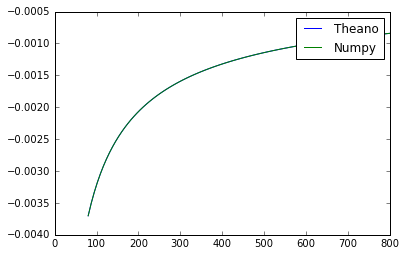

In [50]:
plt.plot(x, dUeqT, label='Theano')
plt.plot(x, dUeq, label='Numpy')
plt.legend()

Benchmarking

In [54]:
N = 1000000
x = np.linspace(1., 10., N) * D
y = np.zeros_like(x)
z = np.zeros_like(x)

In [55]:
%%timeit
Tget_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight)

1 loop, best of 3: 209 ms per loop


In [56]:
%%timeit
get_dUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight, a1, a2, a3, a4, b1, b2)

1 loop, best of 3: 13.1 s per loop


Theano is about twice as fast as numpy

50x time faster using GPUs!!! Yeahhh!!

### Funs with analytical gradients.

We calculate the gradient of the sum of dUeq with respect to x

In [57]:
Tsum = TdUeq.sum()
gradsum = T.grad(Tsum, Tx)

In [58]:
ddUeq = theano.function([Tx, Ty, Tz, TRT, TR, TCT, TTI, Tnode_R, Tnode_th, Tweight], gradsum, allow_input_downcast=True)

In [59]:
ddUeqT = ddUeq(x, y, z, RT, R, CT, TI, node_R, node_th, weight)

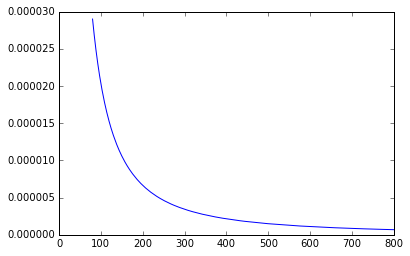

In [60]:
plt.plot(x, ddUeqT, label='gradients')

In [68]:
from windIO.Plant import WTLayout
filename = 'hornsrev.yml'
wtl = WTLayout(filename)
wt_positions = wtl.positions

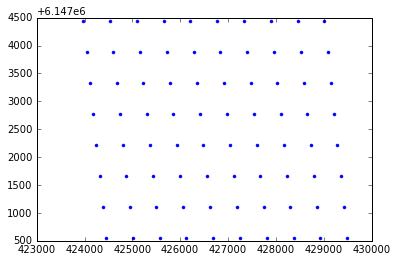

In [67]:
plt.plot(wtl.positions[:,0], wtl.positions[:,1], '.')

In [72]:
from fusedwake.WindFarm import WindFarm

In [73]:
WF = WindFarm(yml=filename)

In [70]:
def turbineDistance(wd, wt_positions):
    angle = np.radians(270.-wd)
    ROT = np.array([[np.cos(angle), np.sin(angle)],
                    [-np.sin(angle), np.cos(angle)]])
    distFlowCoord = np.einsum('ij,jkl->ikl', ROT, wt_positions)
    nDownstream = [(distFlowCoord[0, i, :] < 0).sum() for i in range(self.nWT)]
    ID0 = np.argsort(nDownstream)
    return distFlowCoord, nDownstream, ID0

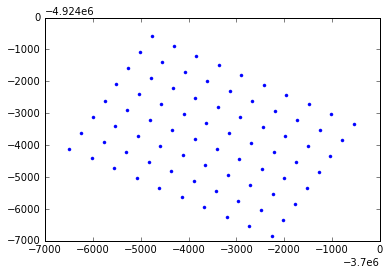

In [91]:
angle = 10
ROT = np.array([[np.cos(angle), np.sin(angle)],
                [-np.sin(angle), np.cos(angle)]])
rot_pos = np.dot(ROT, wt_positions.T).T
plt.plot(rot_pos[:,0], rot_pos[:,1], '.')

In [ ]:

ta = T.tensor3('a')
tb = T.tensor3('b')

tc = T.batched_tensordot(ta, tb, axes=[[1],[1]])

In [230]:
angle = T.scalar('angle')
ROT = T.stacklists([[T.cos(angle), T.sin(angle)],
                    [-T.sin(angle), T.cos(angle)]])
wtp = T.matrix('wtp')
rot_pos = T.dot(ROT, wtp.T).T
Xp = rot_pos[:,0]
Yp = rot_pos[:,1]

In [231]:
rotation = theano.function([angle, wtp], rot_pos, allow_input_downcast=True)

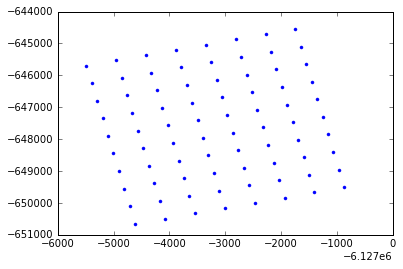

In [242]:
rot_pos2 = rotation(np.radians(270-10.), wt_positions)
plt.plot(rot_pos2[:,0], rot_pos2[:,1], '.')

### Use scan to iterate over the wind farm

In [233]:
def update_farm(U, CT, )

SyntaxError: invalid syntax (<ipython-input-233-c505b890c4d0>, line 1)

###  Testing repeat to build the T2T array

In [234]:
Zp = T.vector('Zp')

DX1 = T.tile(Xp, (Xp.size, 1)).reshape((Xp.size, Xp.size))
DY1 = T.tile(Yp, (Yp.size, 1)).reshape((Yp.size, Yp.size))
DZ1 = T.tile(Zp, (Zp.size, 1)).reshape((Zp.size, Zp.size))
DX = DX1 - DX1.T
DY = DY1 - DY1.T
DZ = DZ1 - DZ1.T

In [237]:
T2T = theano.function([wtp, Zp, angle], [DX, DY, DZ], allow_input_downcast=True)

In [252]:
A,B,C = T2T(wt_positions, np.ones(80)*80., np.radians(270-10.))

In [247]:
distFlowCoord, nDownstream, ID0 = WF.turbineDistance(10)

In [253]:
np.testing.assert_almost_equal(distFlowCoord[0,:,:], A)
np.testing.assert_almost_equal(distFlowCoord[1,:,:], B)
np.testing.assert_almost_equal(distFlowCoord[2,:,:], C)

AssertionError: 
Arrays are not almost equal to 7 decimals

(mismatch 98.75%)
 x: array([[    0.       ,   535.7450346,  1071.316421 , ...,  1802.3799016,
         2337.951288 ,  2873.6963226],
       [ -535.7450346,     0.       ,   535.5713864, ...,  1266.634867 ,...
 y: array([[    0. ,   535.5,  1071. , ...,  1802. ,  2337.5,  2873.5],
       [ -535.5,     0. ,   535.5, ...,  1266.5,  1802. ,  2338. ],
       [-1071. ,  -535.5,     0. , ...,   731. ,  1266.5,  1802.5],...

In [261]:
B

array([[    0.    ,   163.5   ,   328.    , ...,  5781.8125,  5946.3125,
         6109.8125],
       [ -163.5   ,     0.    ,   164.5   , ...,  5618.3125,  5782.8125,
         5946.3125],
       [ -328.    ,  -164.5   ,     0.    , ...,  5453.8125,  5618.3125,
         5781.8125],
       ..., 
       [-5781.8125, -5618.3125, -5453.8125, ...,     0.    ,   164.5   ,
          328.    ],
       [-5946.3125, -5782.8125, -5618.3125, ...,  -164.5   ,     0.    ,
          163.5   ],
       [-6109.8125, -5946.3125, -5781.8125, ...,  -328.    ,  -163.5   ,
            0.    ]], dtype=float32)

In [260]:
distFlowCoord[0,:,:]

array([[    0.        ,   535.74503459,  1071.31642101, ...,
         1802.3799016 ,  2337.95128801,  2873.6963226 ],
       [ -535.74503459,     0.        ,   535.57138642, ...,
         1266.634867  ,  1802.20625342,  2337.95128801],
       [-1071.31642101,  -535.57138642,     0.        , ...,
          731.06348059,  1266.634867  ,  1802.3799016 ],
       ..., 
       [-1802.3799016 , -1266.634867  ,  -731.06348059, ...,
            0.        ,   535.57138642,  1071.31642101],
       [-2337.95128801, -1802.20625342, -1266.634867  , ...,
         -535.57138642,     0.        ,   535.74503459],
       [-2873.6963226 , -2337.95128801, -1802.3799016 , ...,
        -1071.31642101,  -535.74503459,     0.        ]])